In [9]:
import numpy as np
import os
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt

from scipy import signal

from mne.time_frequency import psd_array_multitaper

## Dataset import


In [10]:
# Dicionário para armazenar os dados
original = {}

# Path para o file com os dados
directory = "Data_trials"

# Iterar através de cada pasta de participante
for participant_folder in os.listdir(directory):
    participant_path = os.path.join(directory, participant_folder)
    if os.path.isdir(participant_path):
        participant_number = participant_folder[1:]  # Extrair número do participante do nome da pasta

        # Iterar através dos arquivos MATLAB na pasta do participante
        for file_name in os.listdir(participant_path):
            if file_name.endswith(".mat"):
                file_path = os.path.join(participant_path, file_name)

                # Carregar arquivo MATLAB
                mat_data = loadmat(file_path)

                # Selecionar a key com o nome do file
                keys = mat_data.keys()
                key = list(keys)[3]

                # Criar DataFrame a partir dos dados; .T para transformar linhas em colunas
                df = pd.DataFrame(mat_data[key].T, columns=['TimeStamps','PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2'])

                # Adicionar os dados ao dicionário usando o nome da variável como chave
                if key not in original:
                    original[key] = []
                original[key].append(df)

print(original)

{'P01_T1_R1_1': [      TimeStamps        PO3        POz        PO4        O1         Oz  \
0     123.593750   1.864631  -2.860328   1.653587 -6.425547  -3.635653   
1     123.595703   2.416753  -1.077843   2.950483 -4.994550  -1.967141   
2     123.597656   4.313347   1.916548   6.916747 -2.751511   0.732784   
3     123.599609   6.163780   4.130209  10.570951 -1.644686   2.028786   
4     123.601562   6.490129   4.432967  11.097349 -2.291279   1.016683   
...          ...        ...        ...        ...       ...        ...   
2555  128.583984  -8.472112 -14.553066  -4.899053 -3.590019  -4.270864   
2556  128.585938 -10.756668 -17.010790  -7.277852 -7.278764  -7.616994   
2557  128.587891 -12.720378 -18.316055  -9.205285 -9.548800 -10.001910   
2558  128.589844 -11.026507 -16.585035  -8.335190 -8.101057  -8.968301   
2559  128.591797  -6.623455 -12.930046  -5.479271 -4.359848  -5.893701   

            O2  
0     4.468567  
1     5.550319  
2     7.454867  
3     8.273323  
4     7.0

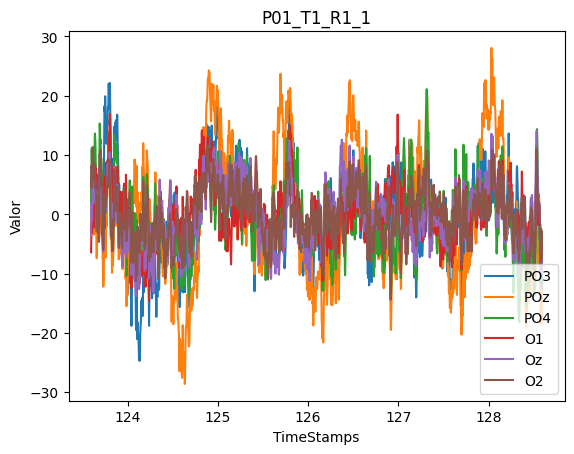

In [11]:
# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in original.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}')
        for data in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for channel in data.columns[1:]:
                plt.plot(data[data.columns[0]], data[channel], label=channel)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()

In [12]:
# Cálculo da frequência de amostragem

data = original['P01_T1_R1_1'][0]

time_diff = data['TimeStamps'].diff().mean()

fs = 1 / time_diff

print("Sampling frequency =", fs, "Hz")

Sampling frequency = 512.0 Hz


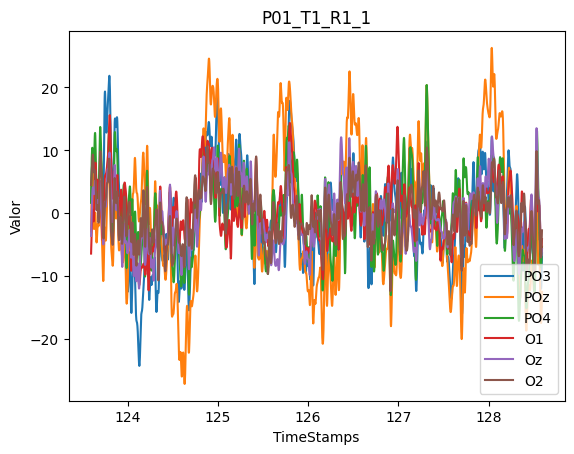

In [13]:
# Definição dos parâmetros do lowpass filter
sos = signal.iirfilter(8, 40, btype='lowpass', analog=False, ftype='butter', fs=fs, output='sos')

#Aplicação de um notch filter para remover frequências de 50 Hz (ruído)
notch_freq = 50.0 
quality_factor = 20.0

b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)

#Dataframe com os dados filtrados
filtrado= {}

#Aplicação do low pass filter
for key, dfs in original.items():
    filtrado[key] = []
    for df in dfs:
        timestamps = df['TimeStamps']
        df_without_timestamps = df.drop(columns=['TimeStamps'])
        df_filtrado = pd.DataFrame(signal.sosfiltfilt(sos, df_without_timestamps.values, axis=0), columns=df_without_timestamps.columns)
        df_filtrado = pd.concat([timestamps, df_filtrado], axis=1)
        filtrado[key].append(df_filtrado)

#Aplicação do notch filter
for key, dfs in filtrado.items():
    for df in dfs:
        for column in df.columns[1:]:
            df[column] = signal.filtfilt(b_notch, a_notch, df[column])


# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in filtrado.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}')
        for data in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for channel in data.columns[1:]:
                plt.plot(data[data.columns[0]], data[channel], label=channel)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()



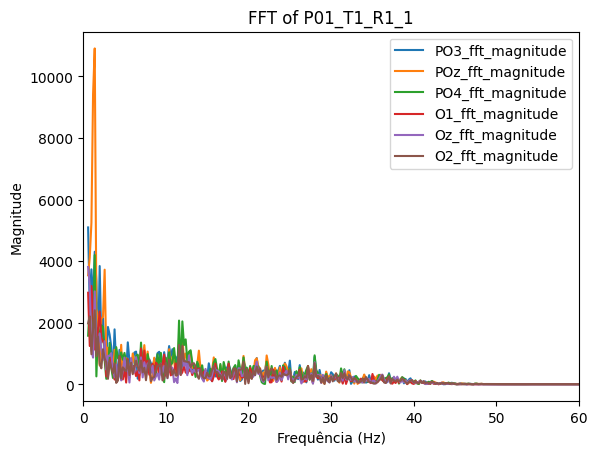

In [14]:
def FFT(x):
    # Cálculo da FFT para o canal atual
    fft_result = np.fft.rfft(x)
    
    # Cálculo do espectro de potência
    power_spectrum = np.abs(fft_result)
    
    # Frequências correspondentes
    frequencies = np.fft.rfftfreq(len(df), d=1/fs)

    return frequencies, power_spectrum

fft = {}

for key, dfs in filtrado.items():
    fft[key] = []
    for df in dfs:
        df_fft = pd.DataFrame()
        df_without_timestamps = df.drop(columns=['TimeStamps'])
        for column in df_without_timestamps.columns:
            freq, X = FFT(df[column])
            df_fft[f"{column}_freq"] = freq
            df_fft[f"{column}_fft_magnitude"] = X
        fft[key].append(df_fft)

for key, dfs in fft.items():
    if key == "P01_T1_R1_1":
        plt.title(f'FFT of {key}')
        for channel in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for column in channel.columns[::2]:  # Seleciona apenas as colunas de frequência
                freq_column = column
                mag_column = column.replace("_freq", "_fft_magnitude")
                freq_positive = channel[freq_column][channel[freq_column] > 0.5]  # Frequências maiores que 0,5 Hz
                mag_positive = channel[mag_column][channel[freq_column] > 0.5]    # Magnitudes correspondentes
                plt.plot(freq_positive, mag_positive, label=mag_column)
        plt.xlim(0, 60)  # Limita o eixo x até 60 Hz
        plt.xlabel('Frequência (Hz)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.show()

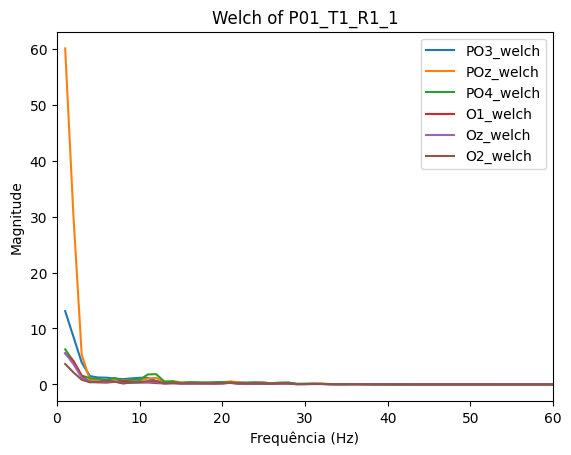

In [15]:
welch = {}

for key, dfs in filtrado.items():
    welch[key] = []
    for df in dfs:
        df_welch = pd.DataFrame()
        df_without_timestamps = df.drop(columns=['TimeStamps'])
        for column in df_without_timestamps.columns:
            freq, welch_data = signal.welch(df[column], fs=fs, nperseg=fs)
            df_welch[f"{column}_freq"] = freq
            df_welch[f"{column}_welch"] = welch_data
        welch[key].append(df_welch)

for key, dfs in welch.items():
    if key == "P01_T1_R1_1":
        plt.title(f'Welch of {key}')
        for channel in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for column in channel.columns[::2]:  # Seleciona apenas as colunas de frequência
                freq_column = column
                mag_column = column.replace("_freq", "_welch")
                freq_positive = channel[freq_column][channel[freq_column] > 0.5]  # Frequências maiores que 0,5 Hz
                mag_positive = channel[mag_column][channel[freq_column] > 0.5]    # Magnitudes correspondentes
                plt.plot(freq_positive, mag_positive, label=mag_column)
        plt.xlim(0, 60)  # Limita o eixo x até 60 Hz
        plt.xlabel('Frequência (Hz)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.show()

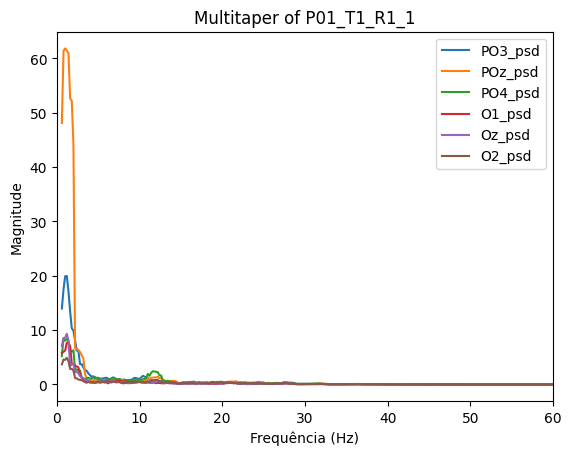

In [16]:
multitaper = {}

for key, dfs in filtrado.items():
    multitaper[key] = []
    for df in dfs:
        df_multitaper = pd.DataFrame()
        df_without_timestamps = df.drop(columns=['TimeStamps'])
        for column in df_without_timestamps.columns:
            psd, freq = psd_array_multitaper(df[column], fs, normalization='full', verbose=0)
            df_multitaper[f"{column}_freq"] = freq
            df_multitaper[f"{column}_psd"] = psd
        multitaper[key].append(df_multitaper)

for key, dfs in multitaper.items():
    if key == "P01_T1_R1_1":
        plt.title(f'Multitaper of {key}')
        for channel in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for column in channel.columns[::2]:  # Seleciona apenas as colunas de frequência
                freq_column = column
                mag_column = column.replace("_freq", "_psd")
                freq_positive = channel[freq_column][channel[freq_column] > 0.5]  # Frequências maiores que 0,5 Hz
                mag_positive = channel[mag_column][channel[freq_column] > 0.5]    # Magnitudes correspondentes
                plt.plot(freq_positive, mag_positive, label=mag_column)
        plt.xlim(0, 60)  # Limita o eixo x até 60 Hz
        plt.xlabel('Frequência (Hz)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.show()